In [2]:
# import packages
import math
import pandas as pd
import numpy as np
from scipy import linalg
import scipy
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
# for classical conf int
from scipy import stats
# load data -- from GOB 
df = pd.read_csv("5dpf_WT_Attributes.csv")
df2 = pd.read_csv("5dpf_hht_Attributes_1-1750.csv")
heart_manual = pd.read_csv("5dpf_Region1_Attributes_Manual.csv")
heart_auto = pd.read_csv("5dpf_Region1_Attributes_Automated.csv")
aorta_manual = pd.read_csv("5dpf_Region2_Attributes_Manual.csv")
aorta_auto = pd.read_csv("5dpf_Region2_Attributes_Automated.csv")
# pandas sauce to make master gold standard set
goldstud = pd.concat([heart_manual, aorta_manual], ignore_index=True)
automaster = pd.concat([heart_auto, aorta_auto], ignore_index=True)
goldstud.head()

,Label,Volume,Elongation,Flatness,Radius,CentroidX,CentroidY,CentroidZ,IntensitySkewness,IntensityMean,IntensitySTD,Axis1length,Axis2length,Axis3length
0,300,178,1.032102,2.487303,3.489612,19.393258,41.129213,46.803371,0,300,0,3.761956,9.357126,9.657510
1,8,470,1.659019,2.614933,4.823213,38.189362,72.365957,47.138298,0,8,0,4.293145,11.226287,18.624627
2,9,556,1.745132,2.460063,5.101079,30.796763,74.516187,49.052158,0,9,0,4.649987,11.439262,19.963026
3,10,347,1.743334,2.339427,4.359269,18.521614,83.731988,50.005764,0,10,0,4.110649,9.616563,16.764885
4,11,385,1.480456,2.322900,4.512917,11.410390,66.896104,51.833766,0,11,0,4.515112,10.488153,15.527251


In [13]:
# define variables for the GOB dataset
y_lab = goldstud['Volume']
yhat_lab = automaster['Volume']
yhat_unlab = df['Volume']
naivemean = df['Volume'].mean()
print("Naive mean: ", naivemean)
classical_goldstdonly = y_lab.mean()
classical = yhat_unlab.mean()
# classical_interval = st.norm.interval(alpha=0.95, loc=classical, scale=st.sem(data)) 
confint = stats.norm.interval(confidence=0.95,loc=df['Volume'].mean())
confint_goldstud = stats.norm.interval(confidence=0.95,loc=goldstud['Volume'].mean())
print("Confidence interval for the naive mean is: ", confint)
#
error_class = (y_lab - yhat_lab).mean()
print("Mean of Gold Standard Set: ", classical_goldstdonly)
print("Confidence interval for the gold standard mean is: ", confint_goldstud)
# 
n = y_lab.shape[0] # stores length of labeled y as n
N = yhat_unlab.shape[0] # stores length of unlabeled y as N
alpha = 0.05
def calcmean(y_lab, yhat_lab, yhat_unlab):
    theta_pp = classical - error_class
    return(theta_pp)

theta_pp_point = calcmean(y_lab, yhat_lab, yhat_unlab)
# print("Classical mean estimate: ", classical)
print("PPI mean estimate: ", theta_pp_point)
testval = []
for i in yhat_unlab:
    xa = (i - classical)**2
    testval = np.append(testval, xa)
# empirical variance
step2 = testval.mean()

# step 3 of algorithm 1
# variance of rectifier
testval2 = []
for i in yhat_lab:
    xb = (i - classical - error_class)**2
    testval2 = np.append(testval2, xb)
step3 = testval2.mean()
#

# step 4 algorithm 1
xc = math.sqrt((step2 / N)+(step3 / n))
step4 = (norm.ppf(1-alpha/2) * xc)
lowbound = (theta_pp_point - step4)
upbound = (theta_pp_point + step4)
print("The prediction powered inference interval for the mean is: ", lowbound, "to ", upbound)


Naive mean:  238.94750528197628
Confidence interval for the naive mean is:  (236.98754129743622, 240.90746926651633)
Mean of Gold Standard Set:  285.96894409937886
Confidence interval for the gold standard mean is:  (284.0089801148388, 287.92890808391894)
PPI mean estimate:  270.2332195676906
The prediction powered inference interval for the mean is:  253.1976569646246 to  287.26878217075654


In [51]:
widthgold = classical_goldstdonly - confint_goldstud[0]
widthnaive = naivemean - confint[0]
widthppi = theta_pp_point - lowbound

In [52]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
dfplot = pd.DataFrame(
    {"x": ['Gold Standard Mean', 'Imputed/Naive Mean', 'Prediction-Powered Mean'], "y": [285.96894409937886, 238.94750528197628, 270.2332195676906], "ci_upper": [confint_goldstud[1], confint[1], upbound], "ci_lower": [confint_goldstud[0], confint[0], upbound]}
)
fig.add_trace(go.Bar(
    name='Mean',
    x=dfplot['x'], y=dfplot['y'],
    error_y=dict(type='data', array=[widthgold, widthnaive, widthppi])
))

<Axes: ylabel='Count'>

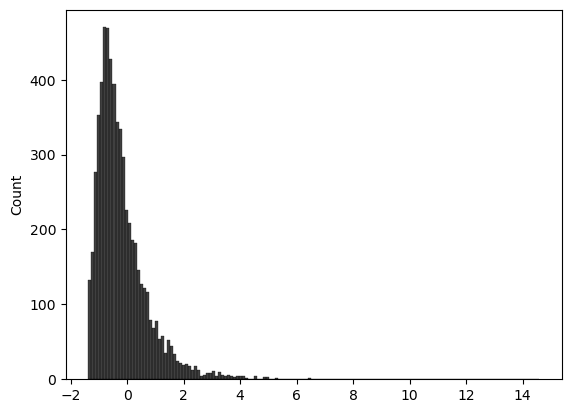

In [53]:
## Calculate z-scores 
differences = []
for i in df['Volume']:
    diffdiff = (theta_pp_point - i)**2
    differences = np.append(differences, diffdiff)
sum(differences)
sd = (sum(differences) / (len(df['Volume']) - 1))**0.5

# should technically use variance of rectifier or step 4?
zscores = []
for i in df['Volume']:
    diffdiff = (i - theta_pp_point) / sd
    zscores = np.append(zscores, diffdiff)

# type(zscores) # ndarray
# z scores calculated by the ppi mean
sns.histplot(zscores, color="black")

In [54]:
## define outliers based on zscore (those with absolute value > 3) and output a list 
# calculate z score from the naive mean
df['zscore'] = stats.zscore(df['Volume'])
# sns.histplot(df['zscore'], color="black")
df['outliermaybe'] = (abs(df['zscore']>3).astype(int))
outlierlist = df[df['outliermaybe'] == 1 ]
# outliers = outlierlist['Label']
# (df.outliermaybe.value_counts())
number1 = len(outlierlist)
print("The number of suspected outliers is: ", number1)

The number of suspected outliers is:  108


In [55]:
## Define OLS and derive variance estimator (sandwich)
# @ operator confers the dot product in numpy aka matmul
# using the moore-penrose pseudoinverse is more sensitive to rank-deficient matrices 
# mp inverse approximates the inverse of non-invertible matrices, and if a matrix has an inverse its mp inverse = its inverse

## x and y must be numpy arrays
# the ols function below takes in ndarrays x and y and returns an ndarray betahat containing the least squares solution for the estimate of beta
def ols(x, y):
    # do I need to add a column of ones to x? -- yes if the goal involves estimating an intercept as well
    xt = x.T
    # a = xt @ xt 
    a = xt @ x
    betahat = linalg.pinv(a) @ xt @ y
    # beta = (x.transpose() * x.transpose()).linalg.inv() * y
    return(betahat)

# define estimator of the variance term 
def resi(x, y, betahat):
    # calculate residual 
    n = len(x)
    resi = y - x @ betahat
    # define sigma squared as the variance of the normal error term
    # finite sample assumption?
    sigmahat = sum(resi ** 2) / (n - 1)
    # would this be realistically (n - 1 - 1) because p = 1
    return(sigmahat)